,Draw,Date,Winning Number 1,Winning Number 2,Winning Number 3,Winning Number 4,Winning Number 5,Winning Number 6,Additional Number,From Last,...,Division 4 Prize,Division 5 Winners,Division 5 Prize,Division 6 Winners,Division 6 Prize,Division 7 Winners,Division 7 Prize,Year,Month,Day_of_Week
0,3766,2022-05-19,5,8,13,20,21,46,31,"21,46",...,288,14856,50,17820,25,242878,10,2022,5,3
1,3765,2022-05-16,21,22,40,41,42,46,9,"41,46",...,445,5535,50,8646,25,106255,10,2022,5,0
2,3764,2022-05-12,15,20,36,38,41,46,10,15,...,469,3928,50,5675,25,73058,10,2022,5,3
3,3763,2022-05-09,5,12,15,21,30,39,6,39,...,195,7834,50,10850,25,117050,10,2022,5,0
4,3762,2022-05-05,7,13,35,39,41,45,1,35,...,436,6063,50,8549,25,115244,10,2022,5,3


/var/folders/26/1sqcgyf96cb0q8fj7pqq1c5m0000gn/T/ipykernel_161/3403023390.py:38: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=freq_df['Number'], y=freq_df['Frequency'], palette='viridis')


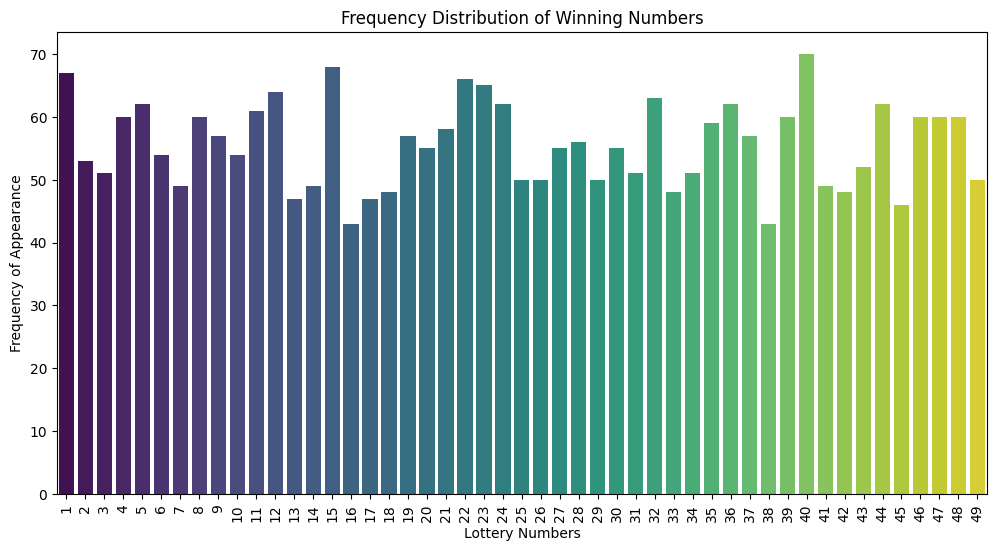


Training models for Winning Number 1

Decision Tree Accuracy for Winning Number 1: 0.0879
              precision    recall  f1-score   support

           1       0.07      0.11      0.08         9
           2       0.29      0.14      0.19        14
           3       0.08      0.10      0.09        10
           4       0.17      0.10      0.12        10
           5       0.17      0.14      0.15         7
           6       0.17      0.25      0.20         4
           7       0.20      0.33      0.25         3
           8       0.00      0.00      0.00         6
           9       0.00      0.00      0.00         5
          10       0.00      0.00      0.00         3
          11       0.00      0.00      0.00         4
          12       0.00      0.00      0.00         3
          13       0.00      0.00      0.00         1
          14       0.00      0.00      0.00         2
          15       0.00      0.00      0.00         0
          16       0.00      0.00      0.00 

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_pr


Random Forest Accuracy for Winning Number 3: 0.0220
              precision    recall  f1-score   support

           5       0.00      0.00      0.00         1
           6       0.00      0.00      0.00         2
           7       0.00      0.00      0.00         1
           8       0.00      0.00      0.00         1
           9       0.00      0.00      0.00         3
          10       0.00      0.00      0.00         2
          11       0.00      0.00      0.00         3
          12       0.00      0.00      0.00         3
          13       0.00      0.00      0.00         3
          14       0.00      0.00      0.00         5
          15       0.10      0.12      0.11         8
          16       0.00      0.00      0.00         3
          17       0.00      0.00      0.00         2
          18       0.00      0.00      0.00         1
          19       0.50      0.17      0.25         6
          20       0.00      0.00      0.00         2
          21       0.00     

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_pr


Random Forest Accuracy for Winning Number 6: 0.0659
              precision    recall  f1-score   support

          26       0.00      0.00      0.00         1
          27       0.00      0.00      0.00         1
          28       0.00      0.00      0.00         1
          29       0.00      0.00      0.00         1
          31       0.00      0.00      0.00         0
          32       0.00      0.00      0.00         1
          33       0.00      0.00      0.00         2
          34       0.00      0.00      0.00         1
          35       0.00      0.00      0.00         3
          36       0.00      0.00      0.00         7
          37       0.00      0.00      0.00         1
          38       0.00      0.00      0.00         2
          39       0.00      0.00      0.00         4
          40       0.00      0.00      0.00         4
          41       0.00      0.00      0.00         4
          42       0.00      0.00      0.00         3
          43       0.00     

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_pr


Decision Tree Hot/Cold Accuracy for Winning Number 1: 0.9890
              precision    recall  f1-score   support

        Cold       1.00      0.98      0.99        61
         Hot       0.97      1.00      0.98        30

    accuracy                           0.99        91
   macro avg       0.98      0.99      0.99        91
weighted avg       0.99      0.99      0.99        91


Training Decision Tree for Hot/Cold classification on Winning Number 2

Decision Tree Hot/Cold Accuracy for Winning Number 2: 1.0000
              precision    recall  f1-score   support

        Cold       1.00      1.00      1.00        71
         Hot       1.00      1.00      1.00        20

    accuracy                           1.00        91
   macro avg       1.00      1.00      1.00        91
weighted avg       1.00      1.00      1.00        91


Training Decision Tree for Hot/Cold classification on Winning Number 3

Decision Tree Hot/Cold Accuracy for Winning Number 3: 1.0000
              pr

/var/folders/26/1sqcgyf96cb0q8fj7pqq1c5m0000gn/T/ipykernel_161/3403023390.py:123: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(next_draw_accuracies.keys()),


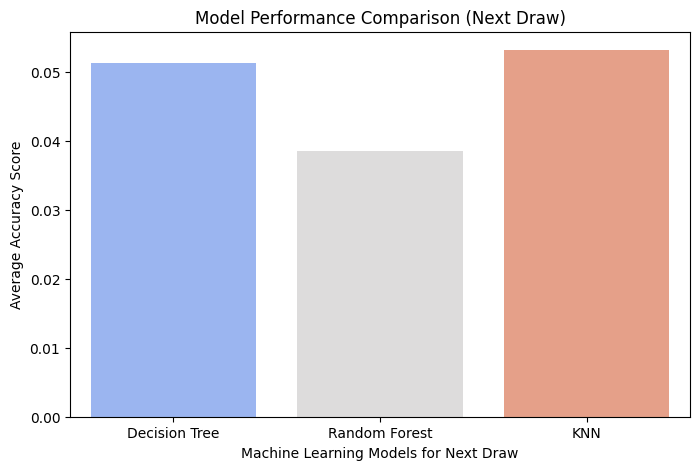

/var/folders/26/1sqcgyf96cb0q8fj7pqq1c5m0000gn/T/ipykernel_161/3403023390.py:133: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(hot_cold_accuracies.keys()),


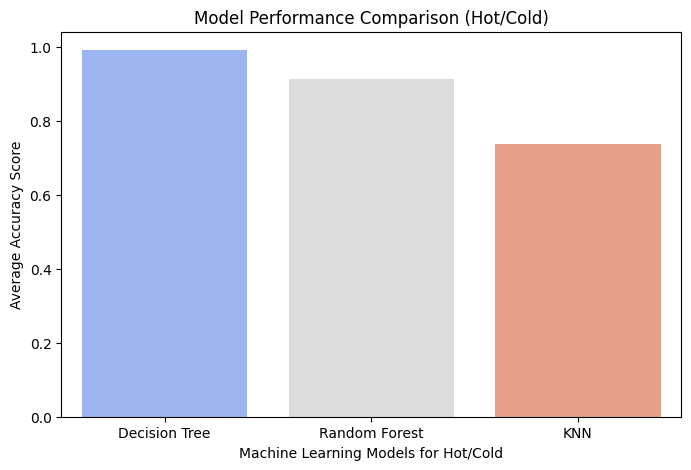

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report

# Load Dataset
df = pd.read_excel('./toto_cleaned_file_with_trends.xlsx')

# Display first few rows
display(df.head())

# Data Cleaning & Feature Engineering
def preprocess_data(df):
    winning_cols = [col for col in df.columns if 'Winning Number' in col]
    data = df[winning_cols].copy()
    data_matrix = data.to_numpy()
    
    # Frequency-based features
    all_numbers = np.arange(1, 50)
    frequency = {num: np.sum(data_matrix == num) for num in all_numbers}
    freq_df = pd.DataFrame(list(frequency.items()), columns=['Number', 'Frequency']).sort_values(by='Frequency', ascending=False)
    
    # Hot/Cold Labeling (Top 20% are Hot)
    threshold = int(len(freq_df) * 0.2)
    freq_df['Label'] = ['Hot' if i < threshold else 'Cold' for i in range(len(freq_df))]
    return data, freq_df

# Preprocess Data
data, freq_df = preprocess_data(df)

# Visualizing Frequency Distribution
plt.figure(figsize=(12,6))
sns.barplot(x=freq_df['Number'], y=freq_df['Frequency'], palette='viridis')
plt.xlabel('Lottery Numbers')
plt.ylabel('Frequency of Appearance')
plt.title('Frequency Distribution of Winning Numbers')
plt.xticks(rotation=90)
plt.show()

# Prepare the Data for Predicting Next Set of Numbers (Multi-Output Classification)
def prepare_next_draw_data(df):
    X = df.iloc[:-1, 2:8].values  # Use past draws as features
    y = df.iloc[1:, 2:8].values   # Use next draw as target
    return X, y

X, y = prepare_next_draw_data(df)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train Separate Models for Each Winning Number
models = {
    'Decision Tree': DecisionTreeClassifier(),
    'Random Forest': RandomForestClassifier(n_estimators=100),
    'KNN': KNeighborsClassifier(n_neighbors=5)
}

# Evaluate models for each winning number position
next_draw_accuracies = {}
for i in range(y_train.shape[1]):  # Loop over each winning number position
    print(f'\nTraining models for Winning Number {i+1}')
    y_train_i = y_train[:, i]
    y_test_i = y_test[:, i]
    
    for name, model in models.items():
        model.fit(X_train, y_train_i)
        y_pred = model.predict(X_test)
        accuracy = accuracy_score(y_test_i, y_pred)
        next_draw_accuracies[name] = next_draw_accuracies.get(name, 0) + accuracy
        print(f'\n{name} Accuracy for Winning Number {i+1}: {accuracy:.4f}')
        print(classification_report(y_test_i, y_pred))

# Average Accuracy for Next Draw Models
for name in next_draw_accuracies:
    next_draw_accuracies[name] /= y_train.shape[1]  # Average accuracy over all winning numbers

# Predicting Hot/Cold Numbers (Binary Classification)
def prepare_hot_cold_data(df, freq_df):
    # Generate Hot/Cold labels based on frequency
    winning_numbers = df.iloc[:, 2:8].values
    # Ensure that we have the correct shape of labels corresponding to the number of rows
    labels = np.array([['Hot' if num in freq_df[freq_df['Label'] == 'Hot']['Number'].values else 'Cold' for num in draw] for draw in winning_numbers])
    
    return winning_numbers, labels

X_hotcold, y_hotcold = prepare_hot_cold_data(df, freq_df)

# Ensure correct shape of y_hotcold for training
X_train, X_test, y_train, y_test = train_test_split(X_hotcold, y_hotcold, test_size=0.2, random_state=42)

# Train Hot/Cold Classifiers
hot_cold_accuracies = {}
hot_cold_models = {
    'Decision Tree': DecisionTreeClassifier(),
    'Random Forest': RandomForestClassifier(n_estimators=100),
    'KNN': KNeighborsClassifier(n_neighbors=5)
}

# Fix the shape of labels and train models
for name, model in hot_cold_models.items():
    for i in range(y_train.shape[1]):  # Loop over each winning number position
        print(f'\nTraining {name} for Hot/Cold classification on Winning Number {i+1}')
        y_train_i = y_train[:, i]  # Select the i-th column of labels
        y_test_i = y_test[:, i]
        
        model.fit(X_train, y_train_i)
        y_pred = model.predict(X_test)
        
        accuracy = accuracy_score(y_test_i, y_pred)
        hot_cold_accuracies[name] = hot_cold_accuracies.get(name, 0) + accuracy
        print(f'\n{name} Hot/Cold Accuracy for Winning Number {i+1}: {accuracy:.4f}')
        print(classification_report(y_test_i, y_pred))

# Average Hot/Cold Accuracy for Models
for name in hot_cold_accuracies:
    hot_cold_accuracies[name] /= y_train.shape[1]  # Average accuracy over all winning numbers

# Display Model Comparison for Next Draw
plt.figure(figsize=(8,5))
sns.barplot(x=list(next_draw_accuracies.keys()), 
            y=list(next_draw_accuracies.values()), 
            palette='coolwarm')
plt.xlabel('Machine Learning Models for Next Draw')
plt.ylabel('Average Accuracy Score')
plt.title('Model Performance Comparison (Next Draw)')
plt.show()

# Display Model Comparison for Hot/Cold Classification
plt.figure(figsize=(8,5))
sns.barplot(x=list(hot_cold_accuracies.keys()), 
            y=list(hot_cold_accuracies.values()), 
            palette='coolwarm')
plt.xlabel('Machine Learning Models for Hot/Cold')
plt.ylabel('Average Accuracy Score')
plt.title('Model Performance Comparison (Hot/Cold)')
plt.show()